In [8]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [9]:
raw_df = pd.read_csv("readingWithSpeed.csv")

In [10]:
print(raw_df.shape)
raw_df.head()

(2832, 15)


,Age,Sex,Race,Marital status?,Education,Employement,Incomes,How many books did you read during last 12months?,Read any printed books during last 12months?,Read any audiobooks during last 12months?,Read any e-books during last 12months?,"Last book you read, you…",Do you happen to read any daily news or newspapers?,Do you happen to read any magazines or journals?,Reading Speed
0,66,Male,Refused,Divorced,College graduate,Retired,"$20,000 to under $30,000",97,Yes,No,Yes,Purchased the book,No,Yes,317
1,46,Male,Native American/American Indian,Married,High school graduate,Employed full-time,"Less than $10,000",97,Yes,Yes,Yes,Purchased the book,Yes,Yes,253
2,32,Male,Mixed race,Never been married,High school graduate,Employed full-time,"Less than $10,000",97,No,Yes,Yes,Borrowed the book from a friend or family member,Yes,Yes,262
3,27,Male,Mixed race,Married,High school graduate,Employed full-time,"$40,000 to under $50,000",97,Yes,No,Yes,Borrowed the book from a library,Yes,No,255
4,16,Female,Mixed race,Never been married,High school incomplete,Employed part-time,"$10,000 to under $20,000",97,Yes,Yes,No,Purchased the book,Yes,No,208


In [11]:
raw_df = raw_df.dropna()
raw_df = raw_df.drop(columns = ['Race', 'Last book you read, you…', 'Incomes'])
raw_df.head()

,Age,Sex,Marital status?,Education,Employement,How many books did you read during last 12months?,Read any printed books during last 12months?,Read any audiobooks during last 12months?,Read any e-books during last 12months?,Do you happen to read any daily news or newspapers?,Do you happen to read any magazines or journals?,Reading Speed
0,66,Male,Divorced,College graduate,Retired,97,Yes,No,Yes,No,Yes,317
1,46,Male,Married,High school graduate,Employed full-time,97,Yes,Yes,Yes,Yes,Yes,253
2,32,Male,Never been married,High school graduate,Employed full-time,97,No,Yes,Yes,Yes,Yes,262
3,27,Male,Married,High school graduate,Employed full-time,97,Yes,No,Yes,Yes,No,255
4,16,Female,Never been married,High school incomplete,Employed part-time,97,Yes,Yes,No,Yes,No,208


In [12]:
raw_df = raw_df.rename(columns={
    "How many books did you read during last 12months?"   : "n_books",
    "Read any printed books during last 12months?"        : "printed_books",
    "Read any audiobooks during last 12months?"           : "audiobooks",
    "Read any e-books during last 12months?"              : "e_books",
    "Do you happen to read any daily news or newspapers?" : "reads_newspaper",
    "Do you happen to read any magazines or journals?"    : "reads_magazines_journals"
})

<h3>Visualização Inicial dos dados<h3>

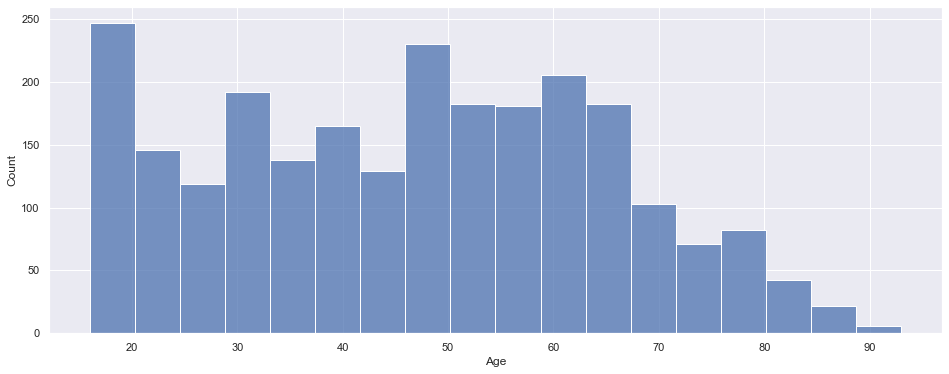

In [13]:
import seaborn as sns
sns.set()

plt.figure(figsize=(16, 6))
sns.histplot(raw_df['Age']);

<h4>Esse gráfico abaixo nos mostra que ha uma forte relação entre educação e velocidade de leitura<h4>

In [14]:
raw_df = raw_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
raw_df.columns

Index(['Age', 'Sex', 'Maritalstatus', 'Education', 'Employement', 'n_books',
       'printed_books', 'audiobooks', 'e_books', 'reads_newspaper',
       'reads_magazines_journals', 'ReadingSpeed'],
      dtype='object')

<b>Limpando as colunas de caracters estranhos<b>

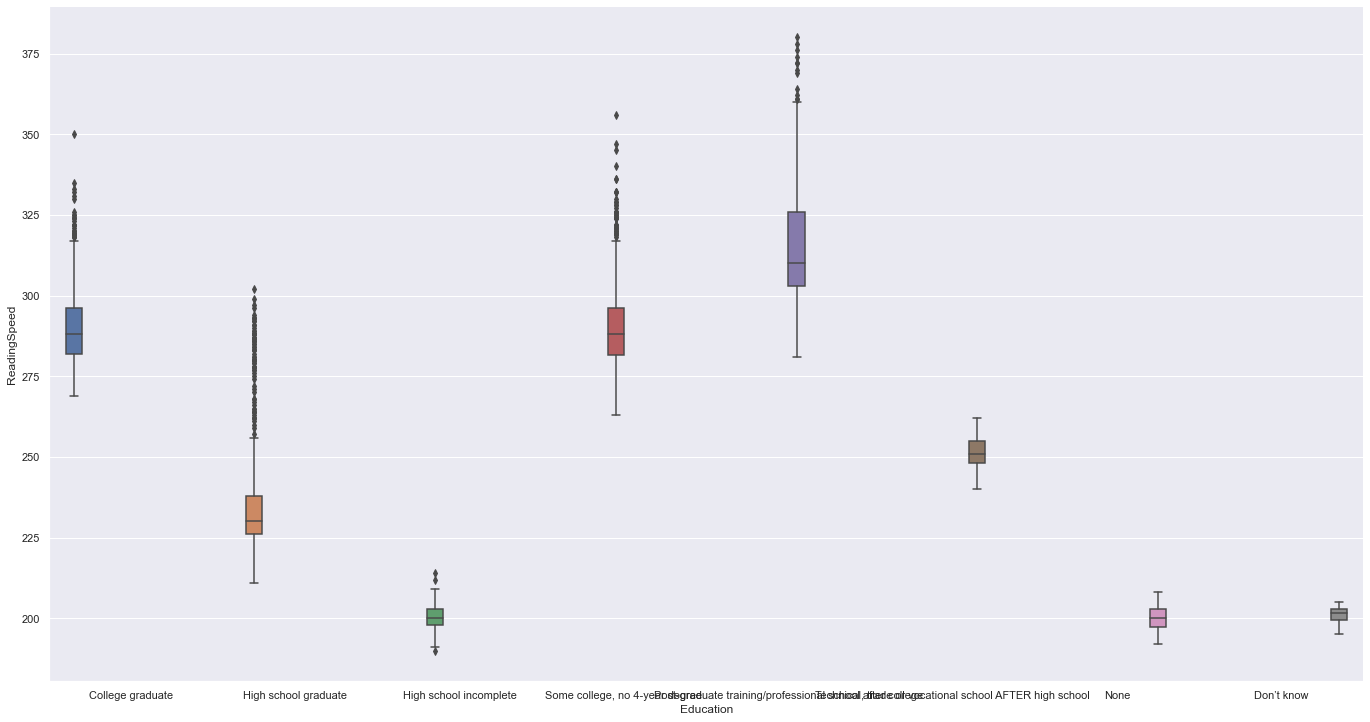

In [15]:
cat = sns.catplot(x="Education", y="ReadingSpeed", data=raw_df, kind="box", height=10, aspect=1.9,  hue="Education", margin_titles=True);

<b>

Fazendo o encoding dos dados categoricos<b>

In [16]:
for column in ['printed_books','audiobooks','e_books','reads_newspaper', 'reads_magazines_journals']:
    raw_df[column] = raw_df[column].replace({'Yes' : 1, 'No': 0, 'Don’t know' : 0})

columns_dont_know = raw_df.columns.drop(['Age', 'n_books', 'Sex'])

raw_df['Maritalstatus'] = raw_df['Maritalstatus'].apply(lambda x: x if x != 'Don’t know' else 'Never been married')

raw_df = pd.get_dummies(raw_df)
raw_df = raw_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

<b>Separando a base em X -> Parametros da análise do modelo e Y -> Alvo, Velocidade de Leitura<b>

In [17]:
y = raw_df['ReadingSpeed']
x = raw_df.drop(columns = ['ReadingSpeed'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 584)

<b>Função genérica para printar os Resultados de Erro Absoluto, Erro Quadratico e o Mais importante a R2 Score do Modelo<b>

In [18]:
def print_results(predictions, y_testy):
    errors = abs(predictions - y_testy)
    sqr_error = abs(predictions - y_testy) ** 2
    out_mape = round(np.mean(errors), 2)
    out_mse = round(np.mean(sqr_error), 2)
    print('Mean Absolute Error:', out_mape, 'degrees.')
    print('Mean squared  Error:', out_mse, 'degrees.')
    r2 = r2_score(predictions, y_testy)
    print('R2 Score', r2, '%.')

    return r2, out_mape, out_mse

<h2>Random Forrest<h2>

<h4>Um dos candidatos ao problema seria um regressor com Random Forest. A razão é que tirando a idade e número de livros lidos, a maioria das features são categóricas com perguntas Sim e Não. O Modelo de random forest em teoria se encaixaria muito bem para esse tipo de problema, por criar árvores de classificação que classificariam nossas velocidades em intervalos. Os testes com o algoritmo usando Cross Validation foram satisfatórios e com eles o Random Forest se mostra um ótimo candidato<h4>

In [19]:
%%time
forest_model_reg = RandomForestRegressor(n_estimators = 100, random_state=37)
scores = cross_val_score(forest_model_reg, x , y, cv = 5, scoring='r2')
results = {"Model| R2 Score": scores.mean(), "uncertainty" : scores.std() * 2}
print(results)

{'Model| R2 Score': 0.9403863352569347, 'uncertainty': 0.10260117994087424}
Wall time: 2.21 s


In [20]:
%%time

forest_model_reg.fit(X_train, y_train)
test = forest_model_reg.predict(X_test)
print_results(test, y_test)

Mean Absolute Error: 5.41 degrees.
Mean squared  Error: 52.92 degrees.
R2 Score 0.9631535191560198 %.
Wall time: 427 ms


(0.9631535191560198, 5.41, 52.92)

<b>R2 Score: 0.9403863352569347<b>
<h4>Tempo médio 542ms<h4>

<h2>GBT<h2>

<b>Agora Para GBT, O Gradient Boosting Trees se encaixaria melhor no projeto, tendo em vista que é similar a Random Forest em ter vários agentes fracos (Tress) e usar eles para achar um resultado melhor. Porém usando do Boosting que seria melhorar esse processo iterativamente ele apresenta normalmente resultados melhores. Testei com Grid Search e Cross Validation e fiquei surpreso com sua r2 score<b>

In [21]:
%%time
gridParams = {
    'learning_rate': [0.01, 0.095, 0.09, 0.085],
    'n_estimators': [100, 200, 300, 400, 500],
    'num_leaves': [10, 15, 20],
    'random_state' : [501], 
    'colsample_bytree' : [0.65, 0.75, 0.8],
    'subsample' : [0.6, 0.75, 0.9],
    'reg_alpha' : [1,1.2, 1.4],
    'reg_lambda' : [1, 1.4, 1.6],
    'bagging_freq' : [5,10]
}

mdl = lgb.LGBMRegressor(boosting_type='gbdt',
                                  objective='regression',
                                  silent=True)

grid = GridSearchCV(estimator=mdl, param_grid=gridParams,
                    scoring='r2',
                    verbose=3,
                    cv=4,
                    n_jobs=-1)
                    

grid.fit(X_train, y_train)
grid.best_params_

Fitting 4 folds for each of 9720 candidates, totalling 38880 fits
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Wall time: 3min 27s


{'bagging_freq': 10,
 'colsample_bytree': 0.8,
 'learning_rate': 0.09,
 'n_estimators': 400,
 'num_leaves': 10,
 'random_state': 501,
 'reg_alpha': 1,
 'reg_lambda': 1.4,
 'subsample': 0.9}

<h4>Salvando os Parametros<h4>

In [25]:
import json

with open('params.json', 'w') as fp:
    json.dump(grid.best_params_, fp)

In [22]:
%%time
gbm = lgb.LGBMRegressor(**grid.best_params_)
scores = cross_val_score(gbm, x , y, cv = 5, scoring='r2')
results = {"Model| R2 Score": scores.mean(), "uncertainty" : scores.std() * 2}
print(results)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
{'Model| R2 Score': 0.9335165014203847, 'uncertainty': 0.09683412543756735}
Wall time: 690 ms


In [23]:
%%time
gbm = lgb.LGBMRegressor(**grid.best_params_)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's l1: 28.811	valid_0's l2: 1275
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 27.69	valid_0's l2: 1178.31
[3]	valid_0's l1: 26.4093	valid_0's l2: 1088.33
[4]	valid_0's l1: 24.412	valid_0's l2: 936.431
[5]	valid_0's l1: 22.6292	valid_0's l2: 811.202
[6]	valid_0's l1: 21.1496	valid_0's l2: 722.09
[7]	valid_0's l1: 19.6357	valid_0's l2: 632.139
[8]	valid_0's l1: 18.6538	valid_0's l2: 577.904
[9]	valid_0's l1: 17.4281	valid_0's l2: 509.848
[10]	valid_0's l1: 16.3024	valid_0's l2: 452.188
[11]	valid_0's l1: 15.258	valid_0's l2: 396.838
[12]	valid_0's l1: 14.2566	valid_0's l2: 346.414
[13]	valid_0's l1: 13.3553	valid_0's l2: 306.196
[14]	valid_0's l1: 12.6401	valid_0's l2: 274.7
[15]	valid_0's l1: 11.9064	valid_0's l2: 245.707
[16]	valid_0's l1: 11.2894	valid_0's l2: 222.178
[17]	valid_0's l1: 10.6744	valid_0's l2: 198.825
[18]	valid_0's l1

<b>R2 Score: 0.9335165014203847<b>
<h4>Tempo médio 48ms<h4>

<b>Fiquei surpreso com o resultado do r2 score, dou isso a 2 fatores. O Primeiro é de que os dados de velocidade da base foram selecionados artificialmente usando dados a respeito de idade e números de livros. O segundo é de que a base ainda é pequena para o problema. Mas de todo jeito irei usar o GBT por 2 razões: A primeira é de que não houve tanta diferença assim apenas de 0.01 entre elas; A segunda é que  o gbt é aproximadamente 1 ordem de grandeza mais rápido que o random forest. Isso pode vir a ser útil no futuro pensando na escalabilidade do App <b>

<h2>Support Vector Machine<h2>

<b>O uso de uma SVM veio como parte de uma entrega da cadeira de Machine Learning. Escolhi a priori o SVM pois é um modelo muito bom para regressão. Ele define uma reta, plano ou hiperplano por uma região dos pontos e maximiza essa região com a reta que quer ser central. Devido a natureza categórica dos dados e o número de features após o encoding, o kernel da SVM falhou em achar um espaço para o problema. <b>

<b>Inicialmente testei os kernels dos modelos utilizando um laço for, para poder indentificar qual seria o mais adequado. Foram testados(RBF, Linear, Polinomial) Minha esprança estava no Kernal Polinomial devido ao numero de features.<b>

In [24]:
%%time
#Suport Vector Regression

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1, cache_size = 1000)
svr_lin = SVR(kernel='linear', C=200, gamma=0.05, cache_size = 1000)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', epsilon=.1, coef0=1, max_iter= 100)

svrs = [svr_rbf, svr_lin, svr_poly]
index = ['rbf', 'linear', 'poly']
for ix, svr in enumerate(svrs):
    print(index[ix])
    predictions = svr.fit(X_train, y_train).predict(X_test)
    print_results(predictions, y_test)

rbf
Mean Absolute Error: 16.11 degrees.
Mean squared  Error: 576.41 degrees.
R2 Score 0.2817010371928256 %.
linear
Mean Absolute Error: 8.1 degrees.
Mean squared  Error: 158.19 degrees.
R2 Score 0.8769743393848979 %.
poly
Mean Absolute Error: 292.82 degrees.
Mean squared  Error: 505430.05 degrees.
R2 Score -0.010883960308320395 %.
Wall time: 1min 1s
C:\Users\Henrique Joaquim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


<b>Como podemos ver o modelo falha para esse tipo de atividade. O Rbf é péssimo, o modelo linear foi melhor do que o esperado mas ainda ruim e o modelo polinomial sofre bastante. Além de lerdo entra em um loop infinito(não sei se realmente entra ou não, isso é indecidível) sem ter um número máximo de iterações. <b>

<h2>Considerando os 3 algoritmos, minha escolha será o GBT. Mais considerações na pipeline.
<h2>